# COVID-19 Exploration

We explore the latest COVID-19 data from https://covidtracking.com/data.

This analysis was inspired in part by this article by Erin Bromage (https://www.erinbromage.com/post/the-risks-know-them-avoid-them).  In particular, she notes that, while new cases are slowing in New York, the pace is still high in much of the United States.  Below, we take a quick look at that breakdown and then explore some other views of the latest numbers.

**Last Update:** 2020-05-17

**Contents:**

* [Load & Clean Data](#Load-&-Clean-Data)
* [All States](#All-States)
* [New York vs The Rest Of US](#New-York-vs-The-Rest-Of-US)
* [Top 10 States](#Top-10-States)
* [Testing](#Testing)
* [Non-Cumulative Deaths](#Non-Cumulative-Deaths)
* [Per-Capita Numbers](#Per-Capita-Numbers)
* [Map Visualizations](#Map-Visualizations)
* [Conclusions](#Conclusions)

In [1]:
import numpy as np
import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import seaborn as sns

import bokeh.plotting as bp
import bokeh.models as bm
import bokeh.layouts as bl
from bokeh.palettes import brewer
from bokeh.resources import CDN, INLINE

In [2]:
plt.rc('figure', facecolor='w', dpi=130, figsize=(5,3.5))
plt.rc('grid', alpha=.33)
bp.output_notebook(INLINE)

Loading BokehJS ...

## Load & Clean Data

We can download the entire spreadsheet from Google Docs.  The URL might go stale in the future, but hopefully an up-to-date link will be maintained at https://covidtracking.com/data.

In [3]:
%%time
x = pd.read_html('https://docs.google.com/spreadsheets/u/2/d/e/'
                 '2PACX-1vRwAqp96T9sYYq2-i7Tj0pvTf6XVHjDSMIKBdZHXiCGGdNC0ypEU9NbngS8mxea55JuCFuua1MUeOj5'
                 '/pubhtml', skiprows=1, index_col=0)

CPU times: user 6.38 s, sys: 42.5 ms, total: 6.42 s
Wall time: 6.88 s


This gives us several tables:

In [4]:
for (i,df) in enumerate(x):
    print(80 * '-')
    print(f'Table {i+1}')
    print(80 * '-')
    display(df.dropna(how='all').head(1))

--------------------------------------------------------------------------------
Table 1
--------------------------------------------------------------------------------


Unnamed: 1 Unnamed: 2
1                                                              
2  The COVID Tracking Project, launched from The ...        NaN

--------------------------------------------------------------------------------
Table 2
--------------------------------------------------------------------------------


State  Unnamed: 2  Positive  Negative  Pending  \
1                                                    
2.0    AK         NaN     392.0   32889.0      NaN   

     HospitalizedÂ â Currently  Hospitalized â Cumulative  \
1                                                               
2.0                         10.0                          NaN   

     In ICU âÂ Currently  In ICU âÂ Cumulative  \
1                                                    
2.0                    NaN                     NaN   

     On Ventilator âÂ Currently  On Ventilator âÂ Cumulative  Recovered  \
1                                                                             
2.0                           NaN                            NaN      344.0   

     Deaths Last update (ET) Check time (ET)  
1                                             
2.0    10.0       5/16 00:00      5/16 15:50

--------------------------------------------------------------------------------
Table 3
--------------------------------------------------------------------------------


Positive  Negative  Pending  HospitalizedÂ â Currently  \
1                                                             
2   1458787   9618392     3788                        42896   

   Hospitalized â Cumulative  In ICU âÂ Currently  In ICU âÂ Cumulative  \
1                                                                               
2                       155726                  10509                    6945   

   On Ventilator âÂ Currently  On Ventilator âÂ Cumulative  Recovered  \
1                                                                           
2                          5529                            592     268376   

   Deaths  
1          
2   83015

--------------------------------------------------------------------------------
Table 4
--------------------------------------------------------------------------------


Date State  Positive  Negative  Pending  \
1                                                    
2.0  20200516.0    AK     392.0   32889.0      NaN   

     HospitalizedÂ â Currently  Hospitalized â Cumulative  \
1                                                               
2.0                         10.0                          NaN   

     In ICU âÂ Currently  In ICU âÂ Cumulative  \
1                                                    
2.0                    NaN                     NaN   

     On Ventilator âÂ Currently  On Ventilator âÂ Cumulative  Recovered  \
1                                                                             
2.0                           NaN                            NaN      344.0   

     Deaths Data Quality Grade   Last Update ET  
1                                                
2.0    10.0                  B  5/16/2020 00:00

--------------------------------------------------------------------------------
Table 5
--------------------------------------------------------------------------------


Date  States   Positive   Negative  Pending  \
1                                                        
2.0  20200516.0    56.0  1458787.0  9618392.0   3788.0   

     Hospitalized â Currently  Hospitalized â Cumulative  \
1                                                              
2.0                     42896.0                     155726.0   

     In ICU â Currently  In ICU â Cumulative  On Ventilator â Currently  \
1                                                                               
2.0               10509.0                 6945.0                       5529.0   

     On Ventilator â Cumulative  Recovered   Deaths  
1                                                      
2.0                         592.0   268376.0  83015.0

--------------------------------------------------------------------------------
Table 6
--------------------------------------------------------------------------------


State                                      COVID-19 site  \
1                                                              
2.0    AK  http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...   

                             COVID-19 site (secondary)       Twitter  \
1                                                                      
2.0  http://dhss.alaska.gov/dph/Epi/id/Pages/COVID-...  @Alaska_DHSS   

                                                 Notes  
1                                                       
2.0  Total tests are taken from the annotations on ...

Of these, we'll take just a few columns from `x[3]` and clean up the Date column.

In [5]:
states = x[3][['Date', 'State', 'Positive', 'Negative', 'Pending', 'Recovered', 'Deaths', 'Data Quality Grade']]
states = states[~states.Date.isna()]
states = states.sort_values('Date State'.split(), ascending=True).reset_index(drop=True)
states['Date'] = pd.to_datetime(states.Date.astype(str), format='%Y%m%d')
states['days'] = states.Date.map({d:i for (i,d) in enumerate(np.unique(states.Date.values))})

In [6]:
print(states.shape)
states.tail()

(4049, 9)


Date State  Positive  Negative  Pending  Recovered  Deaths  \
4044 2020-05-16    VT     934.0   21342.0      NaN      804.0    53.0   
4045 2020-05-16    WA   17951.0  255352.0      NaN        NaN   992.0   
4046 2020-05-16    WI   12187.0  134206.0    189.0     6542.0   453.0   
4047 2020-05-16    WV    1457.0   71936.0      NaN      889.0    64.0   
4048 2020-05-16    WY     716.0   15678.0      NaN      496.0     7.0   

     Data Quality Grade  days  
4044                  B   115  
4045                  A   115  
4046                 A+   115  
4047                  B   115  
4048                  B   115

We'll be making lots of timeseries plots, so the following will help with getting clean axis ticks.

In [7]:
# start from February
xtickdatesf = pd.to_datetime('2020-02-01 2020-03-01 2020-04-01 2020-05-01'.split())
# start from March
xtickdatesm = xtickdatesf[1:]

## All States

We can get a quick initial overview with a simple Seaborn lineplot:

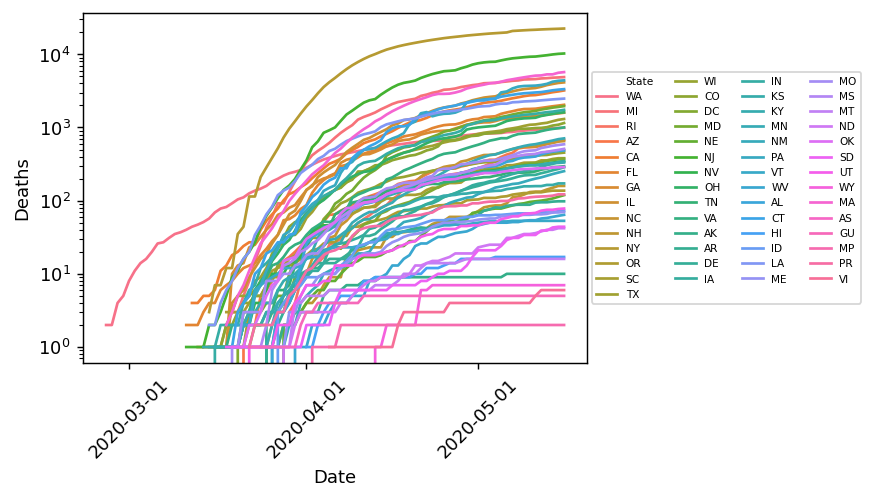

In [8]:
sns.lineplot('Date', 'Deaths', data=states, hue='State')
legend = plt.legend(loc='center left', bbox_to_anchor=[1, .5], ncol=4, prop=dict(size='xx-small'))
plt.xticks(xtickdatesm)
plt.semilogy()
plt.xticks(rotation=45);

## New York vs The Rest Of US

This is what I was initially interested in: how are we doing aside from New York, which had the most severe outbreak in America and subsequently took some of the more intense countermeasures?

In [9]:
totals = states.groupby('Date days'.split(), as_index=False) \
        .agg(dict(Deaths=sum, Positive=sum, Negative=sum, Pending=sum, Recovered=sum))

is_NY = states.State.eq('NY')
NY = states[is_NY]
totals_minus_NY = states[~is_NY].groupby('Date days'.split(), as_index=False) \
        .agg(dict(Deaths=sum, Positive=sum, Negative=sum, Pending=sum, Recovered=sum))

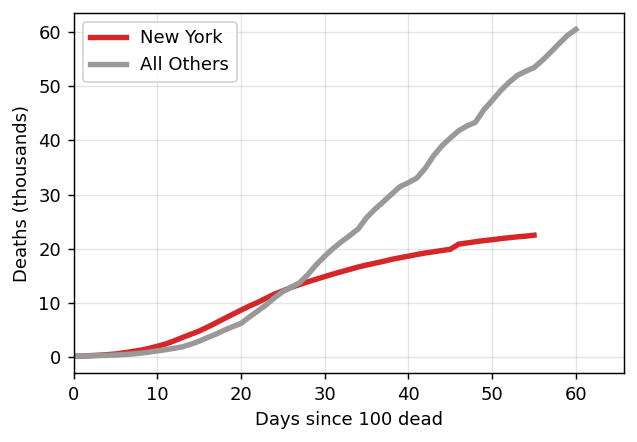

In [10]:
fig, ax = plt.subplots()
f = 1e3
ndead = 100

d = NY
d0 = d.days[d.Deaths >= ndead].values[0]
ax.plot(d.days - d0, d.Deaths/f, color='C3', lw=3, label='New York')
d = totals_minus_NY
d0 = d.days[d.Deaths >= ndead].values[0]
ax.plot(d.days - d0, d.Deaths/f, color='.6', lw=3, label='All Others')
ax.legend(loc='upper left')
ax.grid()
ax.set_xlim(0)
ax.set_xlabel(f'Days since {ndead} dead')
ax.set_ylabel('Deaths (thousands)')
plt.tight_layout()

Logarithmic plots are often used to track the pandemic, and for good reason – how else can we simultaneously view early and late trends in the face of exponential viral spread?  But a linear plot makes clear that deaths are still very much on the rise.

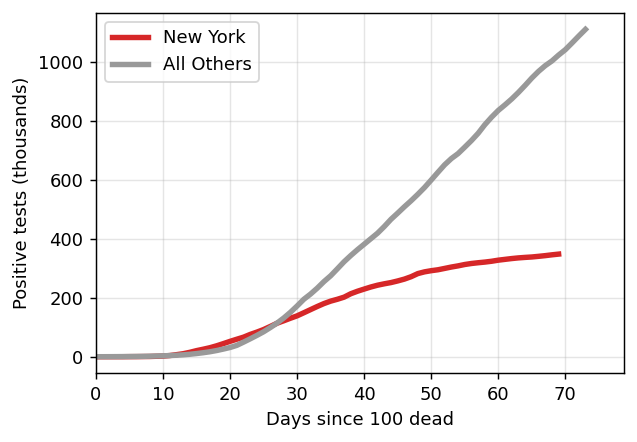

In [11]:
fig, ax = plt.subplots()
f = 1e3
ndead = 100

d = NY
d0 = d.days[d.Positive >= ndead].values[0]
ax.plot(d.days - d0, d.Positive/f, color='C3', lw=3, label='New York')
d = totals_minus_NY
d0 = d.days[d.Positive >= ndead].values[0]
ax.plot(d.days - d0, d.Positive/f, color='.6', lw=3, label='All Others')
ax.legend(loc='upper left')
ax.grid()
ax.set_xlim(0)
ax.set_xlabel(f'Days since {ndead} dead')
ax.set_ylabel('Positive tests (thousands)')
plt.tight_layout()

Deaths are, of course, a lagging indicator – it can take weeks for the virus to kill a person.  Nevertheless, the situation isn't looking much better in terms of positive tests.

## Top 10 States

We cherry-picked New York above, following Erin Bromage's observations.  But this obscures the situation in other states with significant outbreaks.  Let's look at the top 10 states in terms of deaths to date.

In [12]:
nstates = 10
top_n_states = states.groupby('State').Deaths.max().sort_values(ascending=False).index.values[:nstates]
top_n_states

array(['NY', 'NJ', 'MA', 'MI', 'PA', 'IL', 'CT', 'CA', 'LA', 'FL'],
      dtype=object)

In [13]:
def days_since(df, n=100, col='Deaths'):
    mask = df[col] >= n
    if not mask.sum():
        return None
    d0 = df[mask].days.values.min()
    return df.days - d0

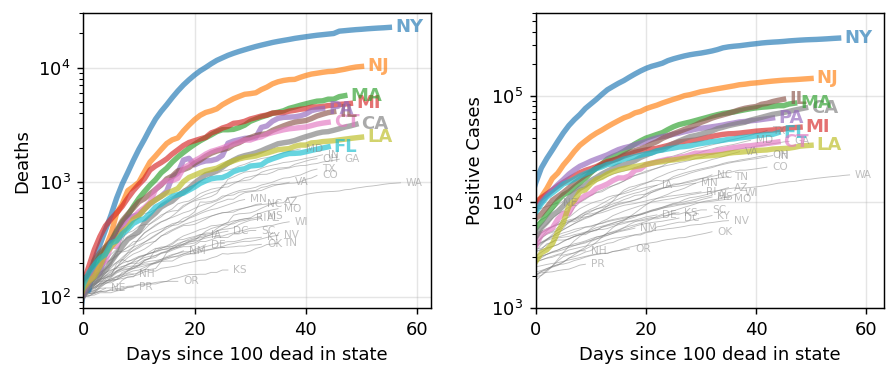

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(7,3))
for (ax, col) in zip(axs, ['Deaths', 'Positive']):
    ndead = 100
    for (i,state) in enumerate(top_n_states):
        d = states[states.State.eq(state)]
        days = days_since(d, ndead)
        line = ax.plot(days, d[col], label=state, lw=3, alpha=.66)[0]
        color = line.get_color()
        ax.text(days.max() + 1, d[col].max(), state, color=color, va='center', alpha=.66, zorder=50-i, weight='bold')
    for state in states.State.unique():
        if state in top_n_states:
            continue
        d = states[states.State.eq(state)]
        days = days_since(d, ndead)
        if days is None:
            continue
        ax.plot(days_since(d, ndead), d[col], color='.5', alpha=.5, lw=.5, zorder=-20)
        ax.text(days.max() + 1, d[col].max(), state, color='.5', va='center', alpha=.5, zorder=20, size='xx-small')
    ax.set_xlim(0)
    #ax.legend(loc='center left', bbox_to_anchor=[1, .5], title='State')
    ax.grid()
    ax.set_xlabel(f'Days since {ndead} dead in state')
    ax.semilogy()
axs[0].set_ylim(.8*ndead, 3e4)
axs[0].set_ylabel('Deaths')
axs[1].set_ylim(1e3, 6e5)
axs[1].set_ylabel('Positive Cases')
plt.tight_layout()
fig.subplots_adjust(wspace=.3)

As has been widely reported, in addition to the mid-Atlantic region, there are significant outbreaks in the Midwest, Southeast, and California.

As noted above, the logarithmic axis lets us see everything, but it makes comparisons difficult.

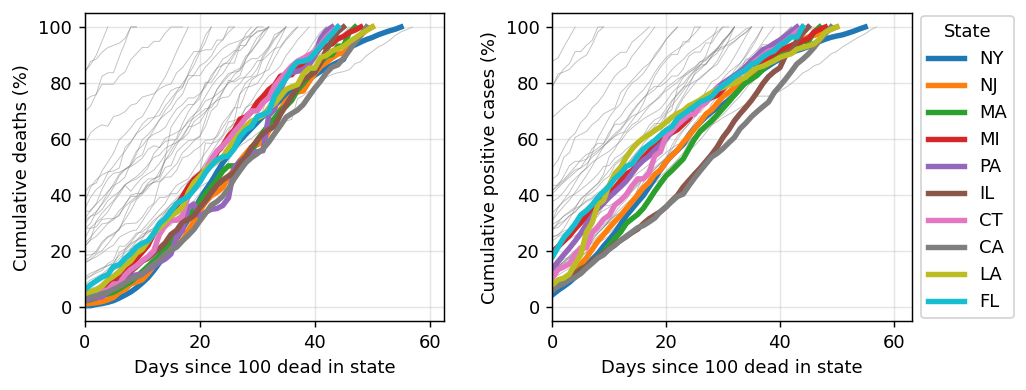

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(8,3.1))
ndead = 100
for (ax, col) in zip(axs, ['Deaths', 'Positive']):
    for state in top_n_states:
        d = states[states.State.eq(state)]
        ax.plot(days_since(d, ndead), 100 * d[col] / d[col].max(), label=state, lw=3)
    for state in states.State.unique():
        if state in top_n_states:
            continue
        d = states[states.State.eq(state)]
        days = days_since(d, ndead)
        if days is None:
            continue
        ax.plot(days_since(d, ndead), 100 * d[col] / d[col].max(), color='.5', alpha=.5, lw=.5, zorder=-20)
    ax.set_xlim(0)
    ax.grid()
    ax.set_xlabel(f'Days since {ndead} dead in state')
axs[0].set_ylabel('Cumulative deaths (%)')
axs[1].set_ylabel('Cumulative positive cases (%)')
axs[1].legend(loc='center left', bbox_to_anchor=[1, .5], title='State')
plt.tight_layout()
fig.subplots_adjust(wspace=.3)

By normalizing to deaths-to-date, we can compare the latest trends across states with very different populations (and thus total death rates).  Here we see again that New York is the only state with a significant slowdown in recent days.  

Things are less clear when looking at positive tests in this way.  Positive tests have slowed down significantly in Louisiana, and more recently Michigan.  But they are speeding up in California and Illinois.

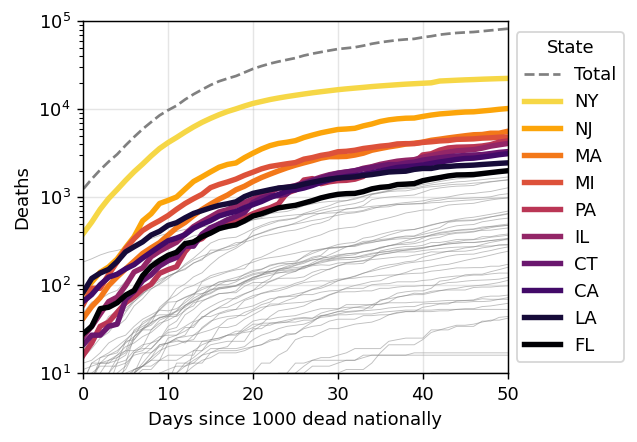

In [17]:
fig, ax = plt.subplots()
ndead = 1000
d0 = totals[totals.Deaths >= ndead].days.values.min()
cmap = plt.get_cmap('inferno_r')
ax.plot(totals.days - d0, totals.Deaths, label='Total', lw=1.5, ls='--', color='.5')
for (i,state) in enumerate(top_n_states):
    d = states[states.State.eq(state)]
    ax.plot(d.days - d0, d.Deaths, label=state, lw=3, color=cmap((i+1)/nstates))
for state in states.State.unique():
    if state in top_n_states:
        continue
    d = states[states.State.eq(state)]
    ax.plot(d.days - d0, d.Deaths, color='.5', alpha=.5, lw=.5, zorder=-20)
ax.set_xlim(0, 50)
ax.set_ylim(10, 1e5)
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=[1, .5], title='State')
ax.semilogy()
ax.set_xlabel(f'Days since {ndead} dead nationally')
ax.set_ylabel('Deaths')
plt.tight_layout()

The details differ from state to state – in part because, frankly, the US Federal response has been an unmitigated disaster.  But overall the trend is consistent: deaths increase at an alarming rate until state government panics, at which point they introduce various half-measures that slow but do not halt viral spread.

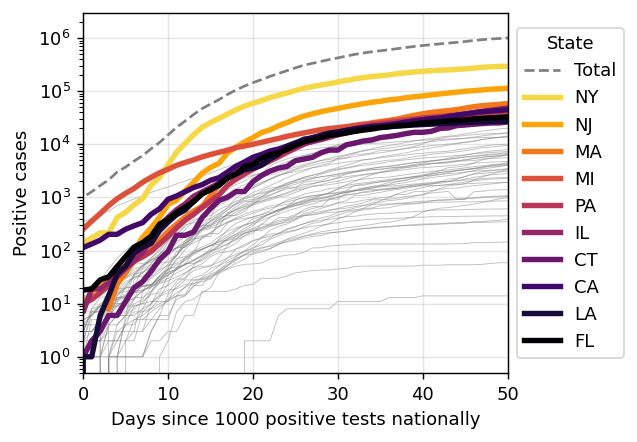

In [18]:
fig, ax = plt.subplots()
npos = 1000
d0 = totals[totals.Positive >= npos].days.values.min()
cmap = plt.get_cmap('inferno_r')
ax.plot(totals.days - d0, totals.Positive, label='Total', lw=1.5, ls='--', color='.5')
for (i,state) in enumerate(top_n_states):
    d = states[states.State.eq(state)]
    ax.plot(d.days - d0, d.Positive, label=state, lw=3, color=cmap((i+1)/nstates))
for state in states.State.unique():
    if state in top_n_states:
        continue
    d = states[states.State.eq(state)]
    ax.plot(d.days - d0, d.Positive, color='.5', alpha=.5, lw=.5, zorder=-20)
ax.set_xlim(0, 50)
#ax.set_ylim(10, 3e4)
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=[1, .5], title='State')
ax.semilogy()
ax.set_xlabel(f'Days since {npos} positive tests nationally')
ax.set_ylabel('Positive cases')
plt.tight_layout()

If the above interpretation is correct, then that could explain why there's arguably more variance in the positive cases curves: testing practices vary, but deaths are much harder to ignore.

## Testing

So about that testing data...

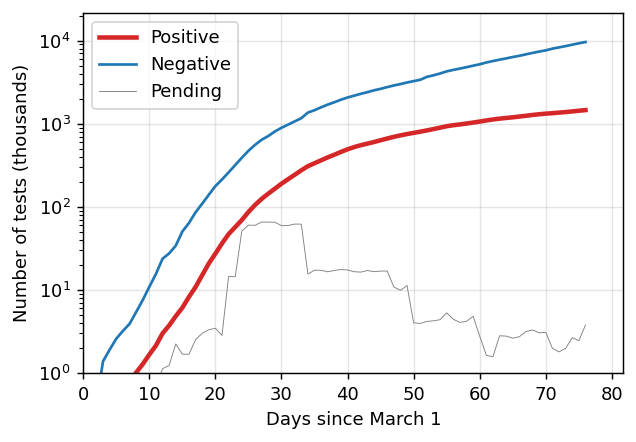

In [19]:
fig, ax = plt.subplots()
colors = 'C3', 'C0', '.5'
d0 = totals[totals.Date >= pd.to_datetime('2020-03-01')].days.min()
for (i,c) in enumerate('Positive Negative Pending'.split()):
    ax.plot(totals.days-d0, totals[c] / 1e3, label=c, color=colors[i], lw=2.5 - i)
ax.semilogy()
ax.set_xlim(0)
ax.set_ylim(1)
ax.set_xlabel('Days since March 1')
ax.set_ylabel('Number of tests (thousands)')
ax.grid()
ax.legend()
plt.tight_layout()

The number of pending tests on a given day is trending downward, which suggests that turn-around time is decreasing.  Meanwhile the number of negative tests is increasing faster than the number of positives.  This suggests that testing is improving overall, which is definitely a good thing.

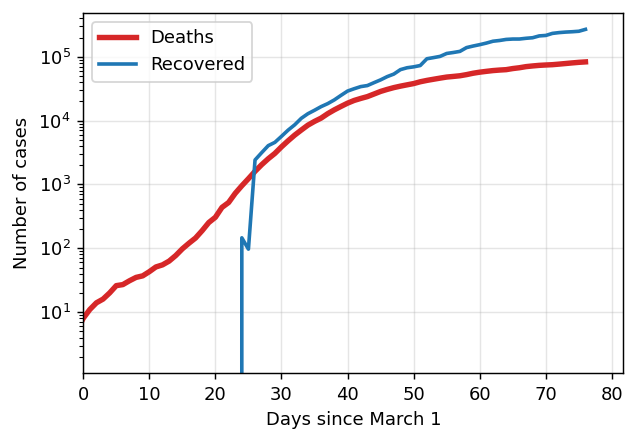

In [20]:
fig, ax = plt.subplots()
ax.plot(totals.days - d0, totals.Deaths, label='Deaths', color='C3', lw=3)
ax.plot(totals.days - d0, totals.Recovered, label='Recovered', color='C0', lw=2)
ax.legend()
ax.semilogy()
ax.set_xlim(0)
ax.set_xlabel('Days since March 1')
ax.set_ylabel('Number of cases')
ax.grid()
plt.tight_layout()

Comparing deaths to recoveries, there appears to be a lag: it takes time to declare a recovery, but we know a death when we see it.  Nevertheless, recoveries are currently increasing at a higher rate than deaths.  Maybe we are slowly getting better at treating the disease?

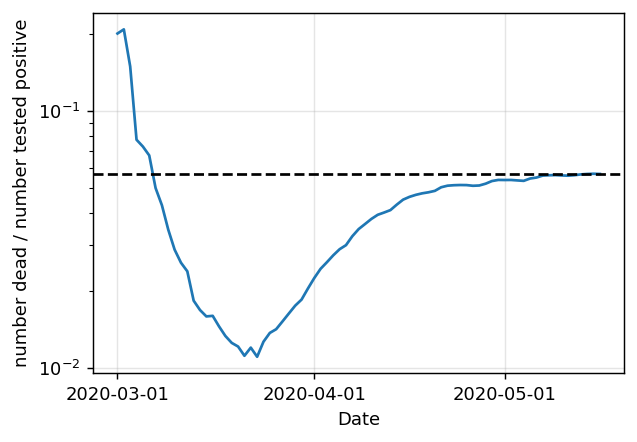

In [21]:
fig, ax = plt.subplots()
d = totals[totals.Date >= pd.to_datetime('2020-03-01')]
ax.plot(d.Date, d.Deaths / d.Positive)
ax.axhline((d.Deaths / d.Positive).values[-1], color='k', ls='--', lw=1.5)
ax.semilogy()
ax.set_xticks(xtickdatesm)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('number dead / number tested positive')
plt.tight_layout()

As mentioned above, deaths naturally lag behind positive tests, at least assuming prompt testing.  Nevertheless, we can look at the ratio of deaths to positive tests to get some handle on the death rate.  Over time this figure seems to be stabilizing around 6% in the US.  This should give some pause regarding any hope that we are rapidly learning how to defeat this "invisible enemy".

## Non-Cumulative Figures

So far, with the exception of pending test results, we've been looking at cumulative numbers.  What about the daily tallies?

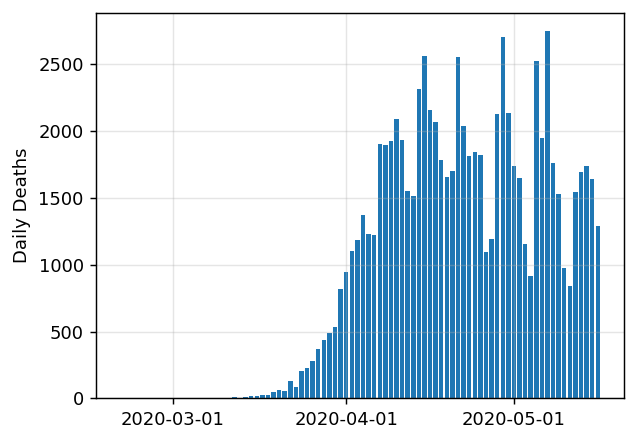

In [22]:
fig, ax = plt.subplots()
d = totals[totals.Date >= pd.to_datetime('2020-02-20')]
#d = totals
ax.bar(d.Date, d.Deaths.diff())
ax.set_xticks(xtickdatesm)
ax.set_ylabel('Daily Deaths')
ax.grid()
plt.tight_layout()

Maybe you've noticed on world-o-meter that daily new deaths seem to decrease on the weekend.  That effect is visible in this dataset as well.

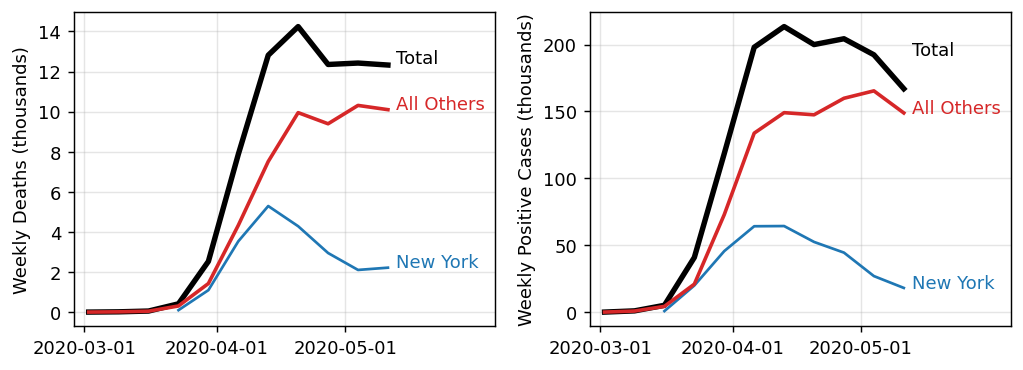

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

ld = totals.Date.max() - pd.to_timedelta('3d')
d0 = pd.to_datetime('2020-02-20')
dn = 5 # day 5 was a monday

for (ax, col) in zip(axs, ['Deaths', 'Positive']):
    d = totals[(totals.Date >= d0)]
    m = ((d.days % 7) == dn)
    y = d[col].rolling(7).sum().diff()[m] / 1e3
    ax.plot(d.Date[m], y, color='k', lw=3)
    ax.text(ld, y.iloc[-2], 'Total', ha='left')

    d = NY[NY.Date >= d0]
    m = ((d.days % 7) == dn)
    y = d[col].rolling(7).sum().diff()[m] / 1e3
    ax.plot(d.Date[m], y)
    ax.text(ld, y.iloc[-1], 'New York', color='C0', ha='left')

    d = totals_minus_NY[totals_minus_NY.Date >= d0]
    m = ((d.days % 7) == dn)
    y = d[col].rolling(7).sum().diff()[m] / 1e3
    ax.plot(d.Date[m], y, color='C3', lw=2)
    ax.text(ld, y.iloc[-1], 'All Others', color='C3', ha='left')

    ax.set_xticks(xtickdatesm)
    ax.set_xlim(right=totals.Date.max() + pd.to_timedelta('20d'))
    ax.grid()
    
axs[0].set_ylabel('Weekly Deaths (thousands)')
axs[1].set_ylabel('Weekly Positive Cases (thousands)')
plt.tight_layout()

There is some danger in smoothing these curves, as we inherently lose detail on the last few days.  But it's still instructive to take a weekly rolling average and compare, once again, New York against the rest of the US.  Once again we see that the apparent progress we've made in slowing the rise of the death toll has indeed been mostly confined to New York.

And that's born out by a more detailed look at the state-by-state breakdown:

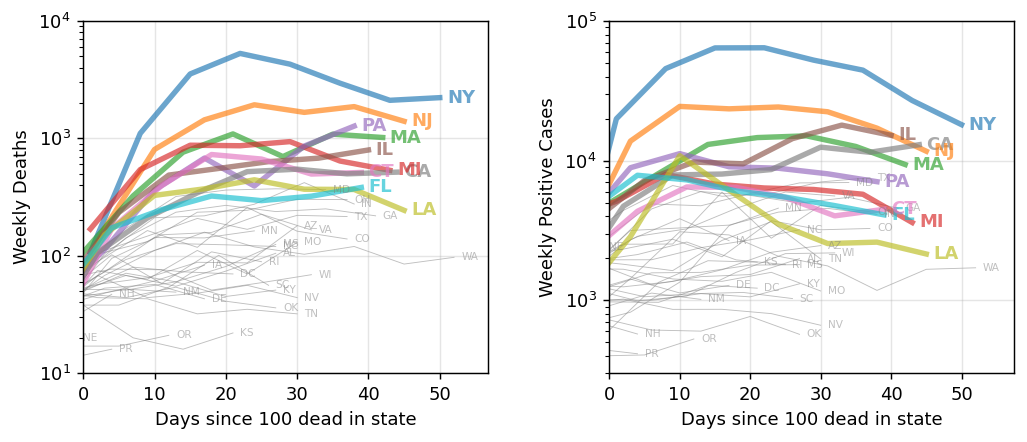

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
ndead = 100
Y = lambda x: x.rolling(7).sum().diff()

for (ax, col) in zip(axs, ['Deaths', 'Positive']):
    for (i,state) in enumerate(top_n_states):
        d = states[states.State.eq(state)]
        m = ((d.days % 7) == dn)
        days = days_since(d, ndead)[m]
        y = Y(d[col])[m]
        line = ax.plot(days, y, label=state, lw=3, alpha=.66)[0]
        color = line.get_color()
        ax.text(days.max() + 1, y.values[-1], state, color=color, va='center', alpha=.66, zorder=50-i, weight='bold')
    for state in states.State.unique():
        if state in top_n_states:
            continue
        d = states[states.State.eq(state)]
        m = ((d.days % 7) == dn)
        days = days_since(d, ndead)
        if days is None:
            continue
        days = days[m]
        y = Y(d[col])[m]
        ax.plot(days, y, color='.5', alpha=.5, lw=.5, zorder=-20)
        ax.text(days.max() + 1, y.values[-1], state, color='.5', va='center', alpha=.5, zorder=20, size='xx-small')
    ax.set_xlim(0)
    ax.semilogy()
    #ax.set_ylim(top=3e3)
    ax.grid()
    ax.set_xlabel(f'Days since {ndead} dead in state')
axs[0].set_ylim(10, 1e4)
axs[0].set_ylabel('Weekly Deaths')
axs[1].set_ylim(3e2, 1e5)
axs[1].set_ylabel('Weekly Positive Cases')
plt.tight_layout()
fig.subplots_adjust(wspace=.3)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


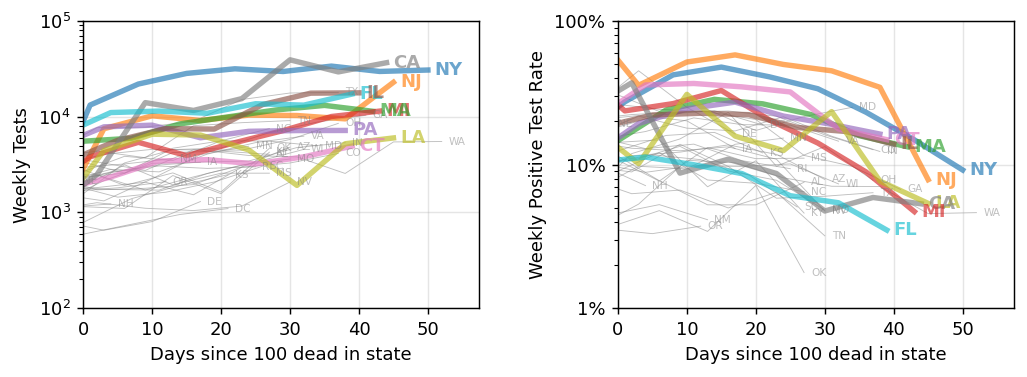

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
ndead = 100

Y0 = lambda x1, x2: x1.rolling(7).mean().diff() + x2.rolling(7).mean().diff()
Y1 = lambda x1, x2: 100 * x1.rolling(7).sum().diff() / x2.rolling(7).sum().diff()

for (ax, Y) in zip(axs, [Y0, Y1]):
    for (i,state) in enumerate(top_n_states):
        d = states[states.State.eq(state)]
        m = ((d.days % 7) == dn)
        days = days_since(d, ndead)[m]
        y = Y(d.Positive, d.Positive + d.Negative)[m]
        #y = Y(d.Positive / (d.Positive + d.Negative))[m]
        line = ax.plot(days, y, label=state, lw=3, alpha=.66)[0]
        color = line.get_color()
        ax.text(days.max() + 1, y.values[-1], state, color=color, va='center', alpha=.66, zorder=50-i, weight='bold')
    for state in states.State.unique():
        if state in top_n_states:
            continue
        d = states[states.State.eq(state)]
        m = ((d.days % 7) == dn)
        days = days_since(d, ndead)
        if days is None:
            continue
        days = days[m]
        y = Y(d.Positive, d.Positive + d.Negative)[m]
        #y = Y(d.Positive / (d.Positive + d.Negative))[m]
        ax.plot(days, y, color='.5', alpha=.5, lw=.5, zorder=-20)
        ax.text(days.max() + 1, y.values[-1], state, color='.5', va='center', alpha=.5, zorder=20, size='xx-small')
    ax.set_xlim(0)
    ax.semilogy()
    ax.grid()
    ax.set_xlabel(f'Days since {ndead} dead in state')
axs[0].set_ylim(1e2, 1e5)
axs[0].set_ylabel('Weekly Tests')
axs[1].set_ylim(1, 1e2)
axs[1].set_yticklabels(['', '1%', '10%', '100%'])
axs[1].set_ylabel('Weekly Positive Test Rate')
plt.tight_layout()
fig.subplots_adjust(wspace=.35)

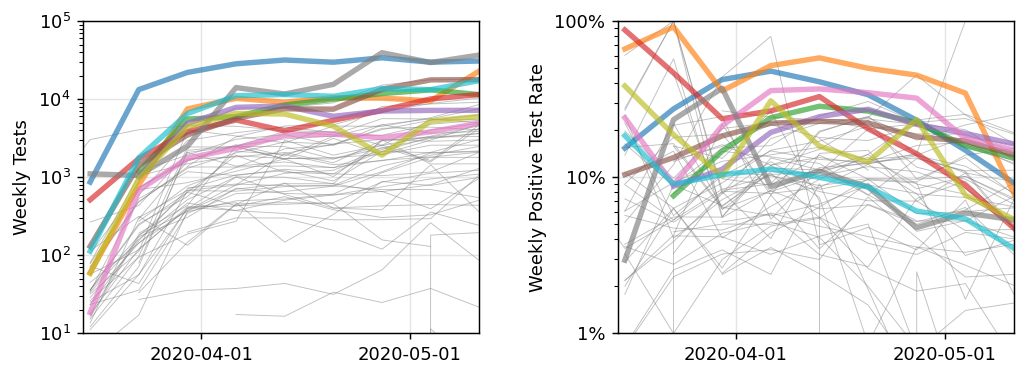

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
ndead = 100

Y0 = lambda x1, x2: x1.rolling(7).mean().diff() + x2.rolling(7).mean().diff()
Y1 = lambda x1, x2: 100 * x1.rolling(7).sum().diff() / x2.rolling(7).sum().diff()

for (ax, Y) in zip(axs, [Y0, Y1]):
    for (i,state) in enumerate(top_n_states):
        d = states[states.State.eq(state)]
        m = ((d.days % 7) == dn)
        days = d.Date[m]
        y = Y(d.Positive, d.Positive + d.Negative)[m]
        line = ax.plot(days, y, label=state, lw=3, alpha=.66)[0]
        color = line.get_color()
        #ax.text(days.max(), y.values[-1], state, color=color, va='center', alpha=.66, zorder=50-i, weight='bold')
    for state in states.State.unique():
        if state in top_n_states:
            continue
        d = states[states.State.eq(state)]
        m = ((d.days % 7) == dn)
        days = d.Date[m]
        y = Y(d.Positive, d.Positive + d.Negative)[m]
        ax.plot(days, y, color='.5', alpha=.5, lw=.5, zorder=-20)
        #ax.text(days.max(), y.values[-1], state, color='.5', va='center', alpha=.5, zorder=20, size='xx-small')
    ax.set_xticks(xtickdatesm)
    ax.set_xlim(pd.to_datetime('2020-03-15'), days.max())
    ax.semilogy()
    ax.grid()
    #ax.set_xlabel(f'Days since {ndead} dead in state')
axs[0].set_ylim(1e1, 1e5)
axs[0].set_ylabel('Weekly Tests')
axs[1].set_ylim(1, 1e2)
axs[1].set_yticklabels(['', '1%', '10%', '100%'])
axs[1].set_ylabel('Weekly Positive Test Rate')
plt.tight_layout()
fig.subplots_adjust(wspace=.35)

## Per-Capita Numbers

After initially posting this on Facebook, I received a request to investigate population-weighted density.  This metric accounts for the average density experienced by _people_, as opposed to by the land.

As far as I can tell, these figures are not readily available.  There is an [R blog post](https://www.r-bloggers.com/weighted-population-density/), which is mirrored [here](http://www.decisionsciencenews.com/2017/06/26/weighted-population-density/).  The mirror has the relevant csv file.  We start there, and follow the blog post to build up population-weighted density from county-level data.

In [25]:
! mkdir -p data
! wget -nc http://www.decisionsciencenews.com/wp-content/uploads/2017/06/DEC_10_SF1_GCTPH1.US05PR.csv -O data/DEC_10_SF1_GCTPH1.US05PR.csv

File ‘data/DEC_10_SF1_GCTPH1.US05PR.csv’ already there; not retrieving.


In [26]:
pop_data = pd.read_csv('data/DEC_10_SF1_GCTPH1.US05PR.csv', skiprows=1, encoding='latin1')
pop_data.columns = [
    'id',
    'state',
    'country',
    'geo_id',
    'geo_id_suffix',
    'geographic_area',
    'name',
    'population',
    'housing_units',
    'total_area',
    'water_area',
    'land_area',
    'population_density',
    'housing_density'
]
pop_data = pop_data['geo_id name population housing_units land_area population_density housing_density'.split()]

Ordinary state numbers are easy enough to get:

In [27]:
pop_states = pop_data[pop_data.geo_id.str.len().eq(11)].copy()
print(pop_states.shape)
pop_states.sort_values('housing_density', ascending=False).head()

(52, 7)


geo_id                  name  population  housing_units  land_area  \
328   0400000US11  District of Columbia      601723         296719      61.05   
1805  0400000US34            New Jersey     8791894        3553562    7354.22   
3195  0400000US72           Puerto Rico     3725789        1636946    3423.78   
2351  0400000US44          Rhode Island     1052567         463388    1033.81   
1239  0400000US25         Massachusetts     6547629        2808254    7800.06   

      population_density  housing_density  
328               9856.5           4860.4  
1805              1195.5            483.2  
3195              1088.2            478.1  
2351              1018.1            448.2  
1239               839.4            360.0

Then we get the county data:

In [28]:
pop_counties = pop_data[pop_data.geo_id.str.len().eq(14)].copy()
pop_counties['state_geo_id'] = pop_counties.geo_id.str.slice(0,11).str.replace('^05', '04')
print(pop_counties.shape)
pop_counties.sort_values('population', ascending=False).head(5)

(3221, 8)


geo_id                name  population  housing_units  \
210   0500000US06037  Los Angeles County     9818605        3445076   
625   0500000US17031         Cook County     5194675        2180359   
2668  0500000US48201       Harris County     4092459        1598698   
107   0500000US04013     Maricopa County     3817117        1639279   
228   0500000US06073    San Diego County     3095313        1164786   

      land_area  population_density  housing_density state_geo_id  
210     4057.88              2419.6            849.0  0400000US06  
625      945.33              5495.1           2306.5  0400000US17  
2668    1703.48              2402.4            938.5  0400000US48  
107     9200.14               414.9            178.2  0400000US04  
228     4206.63               735.8            276.9  0400000US06

In [29]:
d = both = pd.merge(pop_counties, pop_states, left_on='state_geo_id', right_on='geo_id', suffixes=('_county', '_state'))
d['population_weighted_density'] = d.population_county / d.population_state * d.population_density_county
d['housing_weighted_density'] = d.housing_units_county / d.housing_units_state * d.housing_density_county
d = d.groupby('state_geo_id').agg(dict(population_weighted_density=sum, housing_weighted_density=sum))
populations = pd.merge(pop_states, d.astype(int), left_on='geo_id', right_on='state_geo_id', how='left')
populations = populations.drop(columns='geo_id')
populations.head()

name  population  housing_units  land_area  population_density  \
0     Alabama     4779736        2171853   50645.33                94.4   
1      Alaska      710231         306967  570640.95                 1.2   
2     Arizona     6392017        2844526  113594.08                56.3   
3    Arkansas     2915918        1316299   52035.48                56.0   
4  California    37253956       13680081  155779.22               239.1   

   housing_density  population_weighted_density  housing_weighted_density  
0             42.9                          231                       102  
1              0.5                           73                        25  
2             25.0                          271                       113  
3             25.3                          158                        69  
4             87.8                         1739                       699

Then we fetch a name <--> abbreviation mapping from Wikipedia:

In [30]:
wa = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations', skiprows=9)[0]
abbreviations = pd.DataFrame(dict(name=wa['Name and status of region'], State=wa['ANSI'])).dropna()
populations = pd.merge(populations, abbreviations, on='name')
cols = 'name State'.split()
cols += [c for c in populations if c not in cols]
populations = populations[cols].copy()
populations

name State  population  housing_units  land_area  \
0                Alabama    AL     4779736        2171853   50645.33   
1                 Alaska    AK      710231         306967  570640.95   
2                Arizona    AZ     6392017        2844526  113594.08   
3               Arkansas    AR     2915918        1316299   52035.48   
4             California    CA    37253956       13680081  155779.22   
5               Colorado    CO     5029196        2212898  103641.89   
6            Connecticut    CT     3574097        1487891    4842.36   
7               Delaware    DE      897934         405885    1948.54   
8   District of Columbia    DC      601723         296719      61.05   
9                Florida    FL    18801310        8989580   53624.76   
10               Georgia    GA     9687653        4088801   57513.49   
11                Hawaii    HI     1360301         519508    6422.63   
12                 Idaho    ID     1567582         667796   82643.12   
13              Illinois    IL    12830632        5296715   55518.93   
14               Indiana    IN     6483802        2795541   35826.11   
15                  Iowa    IA     3046355        1336417   55857.13   
16                Kansas    KS     2853118        1233215   81758.72   
17              Kentucky    KY     4339367        1927164   39486.34   
18             Louisiana    LA     4533372        1964981   43203.90   
19                 Maine    ME     1328361         721830   30842.92   
20              Maryland    MD     5773552        2378814    9707.24   
21         Massachusetts    MA     6547629        2808254    7800.06   
22              Michigan    MI     9883640        4532233   56538.90   
23             Minnesota    MN     5303925        2347201   79626.74   
24           Mississippi    MS     2967297        1274719   46923.27   
25              Missouri    MO     5988927        2712729   68741.52   
26               Montana    MT      989415         482825  145545.80   
27              Nebraska    NE     1826341         796793   76824.17   
28                Nevada    NV     2700551        1173814  109781.18   
29         New Hampshire    NH     1316470         614754    8952.65   
30            New Jersey    NJ     8791894        3553562    7354.22   
31            New Mexico    NM     2059179         901388  121298.15   
32              New York    NY    19378102        8108103   47126.40   
33        North Carolina    NC     9535483        4327528   48617.91   
34          North Dakota    ND      672591         317498   69000.80   
35                  Ohio    OH    11536504        5127508   40860.69   
36              Oklahoma    OK     3751351        1664378   68594.92   
37                Oregon    OR     3831074        1675562   95988.01   
38          Pennsylvania    PA    12702379        5567315   44742.70   
39          Rhode Island    RI     1052567         463388    1033.81   
40        South Carolina    SC     4625364        2137683   30060.70   
41          South Dakota    SD      814180         363438   75811.00   
42             Tennessee    TN     6346105        2812133   41234.90   
43                 Texas    TX    25145561        9977436  261231.71   
44                  Utah    UT     2763885         979709   82169.62   
45               Vermont    VT      625741         322539    9216.66   
46              Virginia    VA     8001024        3364939   39490.09   
47            Washington    WA     6724540        2885677   66455.52   
48         West Virginia    WV     1852994         881917   24038.21   
49             Wisconsin    WI     5686986        2624358   54157.80   
50               Wyoming    WY      563626         261868   97093.14   
51           Puerto Rico    PR     3725789        1636946    3423.78   

    population_density  housing_density  population_weighted_density  \
0                 94.4             42.9                          231   
1                  1.2              0.5                    

We make a copy of the per-state data that includes death per million residents and compute the top 10 states by that metric:

In [31]:
states2 = pd.merge(states, populations, on='State')
states2['Deaths Per Million'] = states2.Deaths / states2.population * 1e6
states2['Positive Cases Per Million'] = states2.Positive / states2.population * 1e6
states2['Recoveries Per Million'] = states2.Recovered / states2.population * 1e6

top_n_states_pm = states2.groupby('State')['Deaths Per Million'].max().sort_values(ascending=False).index.values[:nstates]
top_n_states_pm

array(['NJ', 'NY', 'CT', 'MA', 'DC', 'LA', 'MI', 'RI', 'PA', 'MD'],
      dtype=object)

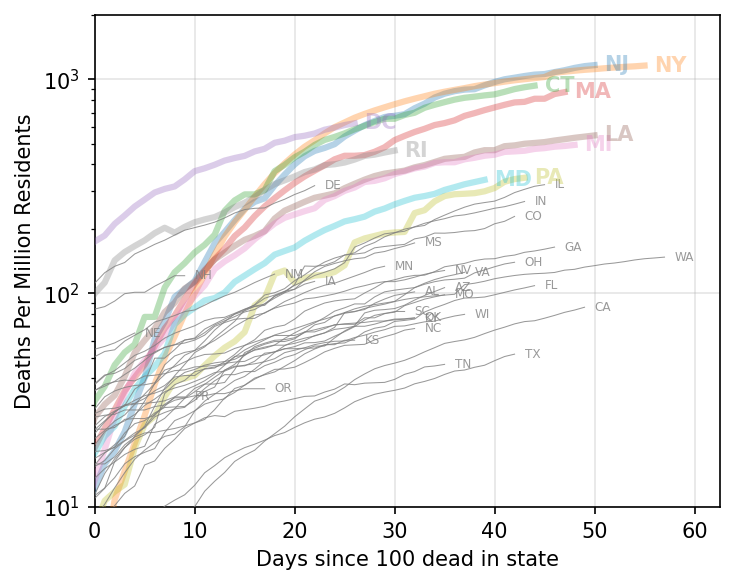

In [32]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
ndead = 100
# dict for overall scaling
dpops = dict(zip(populations.State, populations.population))
for (i,state) in enumerate(top_n_states_pm):
    d = states[states.State.eq(state)]
    days = days_since(d, ndead)
    pop = dpops[state]
    y = d.Deaths / pop * 1e6
    line = ax.plot(days, y, label=state, lw=3, alpha=.33, zorder=10)[0]
    color = line.get_color()
    ax.text(days.max() + 1, y.max(), state, color=color, va='center', alpha=.33, zorder=50-i, weight='bold')
for state in states.State.unique():
    if state in top_n_states_pm:
        continue
    d = states[states.State.eq(state)]
    days = days_since(d, ndead)
    if days is None:
        continue
    pop = dpops[state]
    y = d.Deaths / pop * 1e6
    ax.plot(days_since(d, ndead), y, color='.5', alpha=.8, lw=.5, zorder=20)
    ax.text(days.max() + 1, y.max(), state, color='.5', va='center', alpha=.8, zorder=20, size='xx-small')
ax.set_xlim(0)
ax.set_ylim(10, 2e3)
ax.semilogy()
ax.grid()
ax.set_xlabel(f'Days since {ndead} dead in state')
ax.set_ylabel('Deaths Per Million Residents')
plt.tight_layout()

Here we see a bit more clearly that the fate of a state overall is determined mostly by its urban/rural balance.  It would be best to use population density data directly, but I don't feel like going back to Wikipedia for another table so that remains TODO for me.

In [159]:
latest = states.groupby('State', as_index=False).agg(dict(Deaths=max, Positive=max)).merge(populations, on='State')
latest['Deaths Per Million'] = latest.Deaths / latest.population * 1e6
latest['Positives Per Million'] = latest.Deaths / latest.population * 1e6

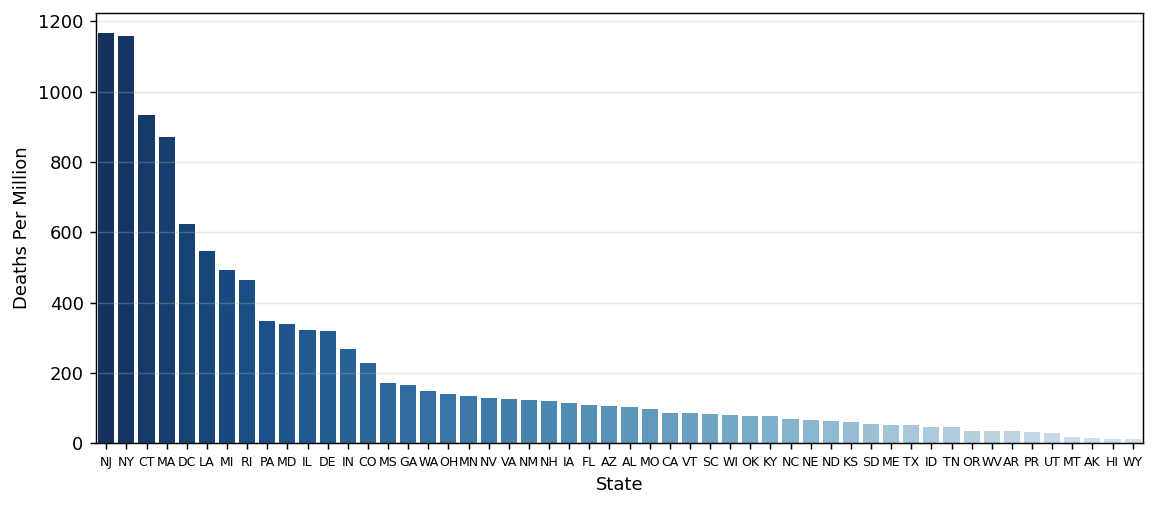

In [154]:
fig, ax = plt.subplots(figsize=(9,4))
sns.barplot('State', 'Deaths Per Million',
            data=latest.sort_values('Deaths Per Million', ascending=False),
            palette=sns.color_palette(plt.get_cmap('Blues')(np.linspace(1, .2, len(latest)))),
            ax=ax)
plt.xticks(size='x-small')
ax.grid(axis='y')
#ax.semilogx()
plt.tight_layout()

This is just another view of the latest total per-capita death tolls.

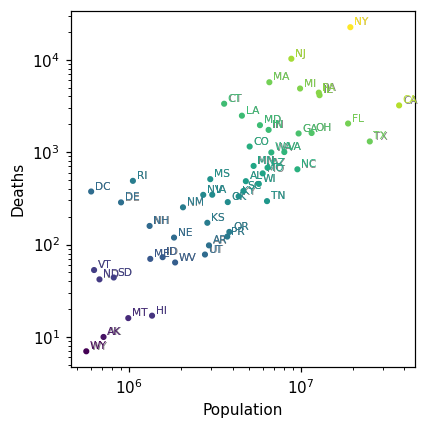

In [35]:
fig, ax = plt.subplots(figsize=(4,4), dpi=110)
d = latest[latest.Deaths > 0]
X = d.population
Y = d['Deaths']
both = np.log(X * Y)
sc = ax.scatter(X, Y, marker='.', c=both)
for (i,(x, y, z)) in enumerate(zip(X.values, Y.values, both.values)):
    x, y = 1.05*x, 1.05*y
    ax.text(x, y, d.State.values[i], color=sc.to_rgba(z), size='x-small')
    offset = 1.005
    ax.text(x*offset, y/offset, d.State.values[i], color='.5', size='x-small', zorder=-20)
ax.loglog()
ax.set_xlabel('Population')
ax.set_ylabel('Deaths')
plt.tight_layout()

Of course, total deaths are highly correlated with population.

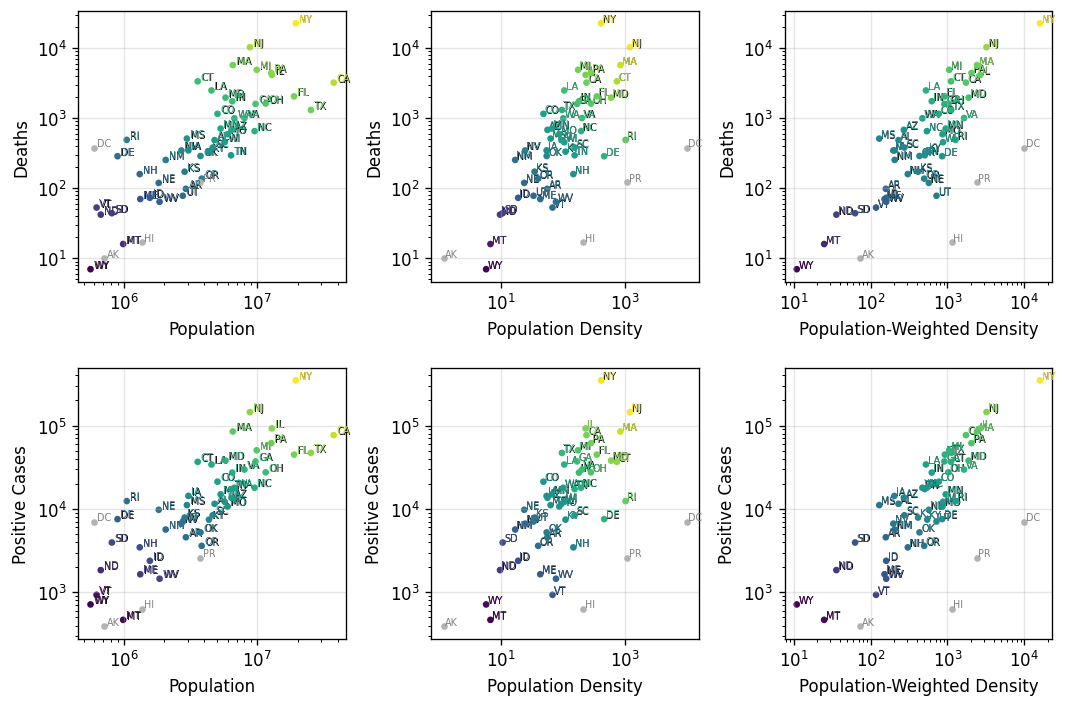

In [163]:
fig, axs = plt.subplots(2, 3, figsize=(9,6), dpi=120)
d = latest[latest.Deaths > 0]
Xs = (d.population, d.population_density, d.population_weighted_density)
Ys = (d.Deaths, d.Positive)
xlabels = 'Population', 'Population Density', 'Population-Weighted Density'
ylabels = 'Deaths', 'Positive Cases'
greys = latest.State.isin('DC PR HI AK'.split())

for (iy, Y) in enumerate(Ys):
    for (ix, X) in enumerate(Xs):
        ax = axs[iy,ix]
        both = np.log(X * Y)
        sc = ax.scatter(X[~greys], Y[~greys], marker='.', c=both[~greys])
        ax.scatter(X[greys], Y[greys], marker='.', c='.7')
        for (i,(x, y, z, g)) in enumerate(zip(X.values, Y.values, both.values, greys.values)):
            x, y = 1.05*x, 1.05*y
            c = '.5' if g else sc.to_rgba(z)
            ax.text(x, y, d.State.values[i], color=c, size='xx-small')
            offset = 1.015
            if not g:
                ax.text(x*offset, y/offset, d.State.values[i], color='k', size='xx-small', zorder=-20)
        ax.loglog()
        ax.set_xlabel(xlabels[ix])
        ax.set_ylabel(ylabels[iy])
        ax.grid()
    
plt.tight_layout()
fig.subplots_adjust(wspace=.32, hspace=.32)

Here we see that deaths and positive cases are much more strongly correlated with population density and population-weighted density than with total population.  This makes sense given that the virus spreads through close person-to-person contact.

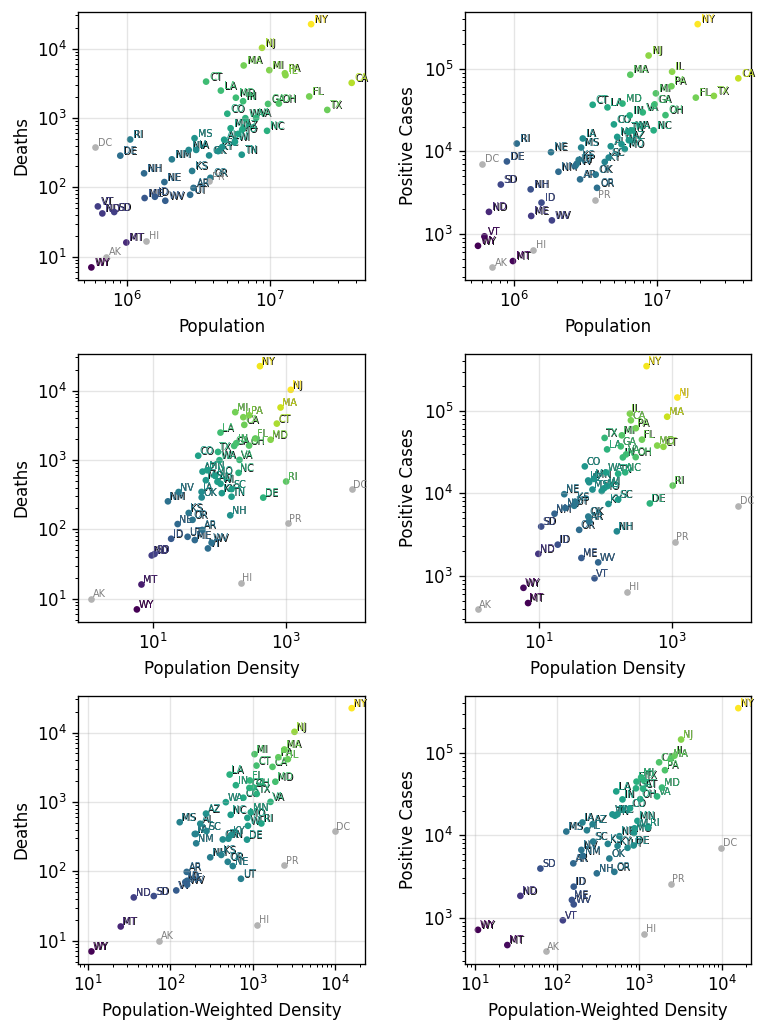

In [172]:
fig, axs = plt.subplots(3, 2, figsize=(6.5,8.7), dpi=120)
d = latest[latest.Deaths > 0]
Xs = (d.population, d.population_density, d.population_weighted_density)
Ys = (d.Deaths, d.Positive)
xlabels = 'Population', 'Population Density', 'Population-Weighted Density'
ylabels = 'Deaths', 'Positive Cases'
greys = latest.State.isin('DC PR HI AK'.split())

for (ix, X) in enumerate(Xs):
    for (iy, Y) in enumerate(Ys):
        ax = axs[ix,iy]
        both = np.log(X * Y)
        sc = ax.scatter(X[~greys], Y[~greys], marker='.', c=both[~greys])
        ax.scatter(X[greys], Y[greys], marker='.', c='.7')
        for (i,(x, y, z, g)) in enumerate(zip(X.values, Y.values, both.values, greys.values)):
            x, y = 1.05*x, 1.05*y
            c = '.5' if g else sc.to_rgba(z)
            ax.text(x, y, d.State.values[i], color=c, size='xx-small')
            offset = 1.015
            if not g:
                ax.text(x*offset, y/offset, d.State.values[i], color='k', size='xx-small', zorder=-20)
        ax.loglog()
        ax.set_xlabel(xlabels[ix])
        ax.set_ylabel(ylabels[iy])
        ax.grid()
    
plt.tight_layout()
fig.subplots_adjust(wspace=.35)

This is just the plot above, transposed so it works better in a blog with margins.

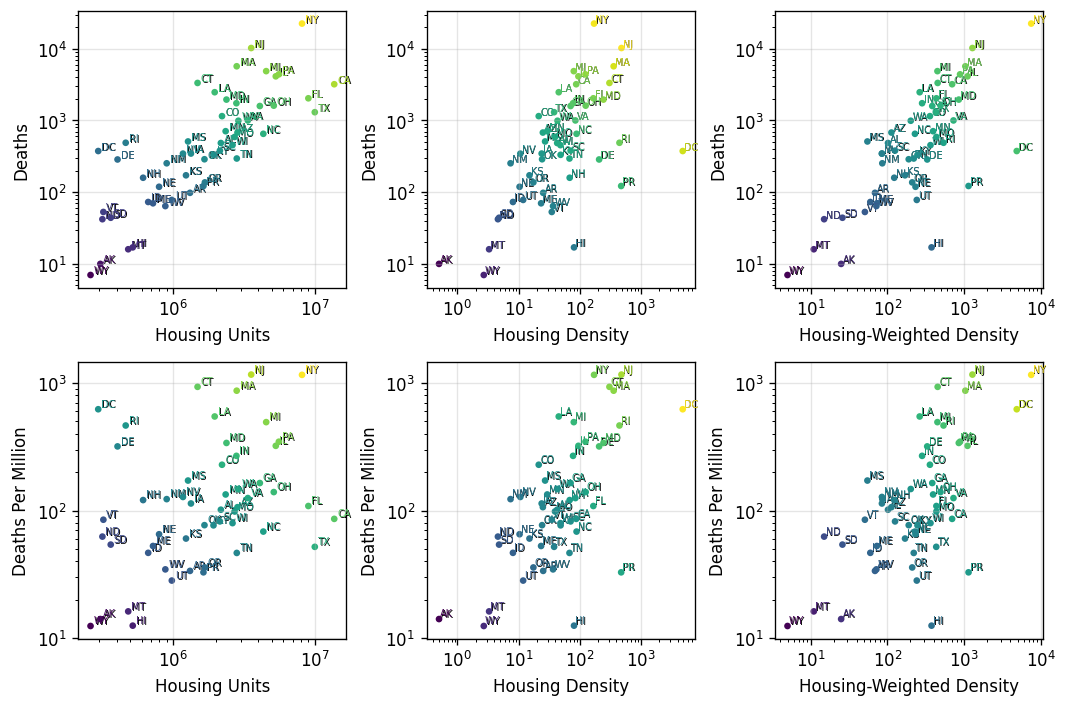

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(9,6), dpi=120)
d = latest[latest.Deaths > 0]
Xs = (d.housing_units, d.housing_density, d.housing_weighted_density)
Ys = (d.Deaths, d['Deaths Per Million'])
xlabels = 'Housing Units', 'Housing Density', 'Housing-Weighted Density'
ylabels = 'Deaths', 'Deaths Per Million'

for (iy, Y) in enumerate(Ys):
    for (ix, X) in enumerate(Xs):
        ax = axs[iy,ix]
        both = np.log(X * Y)
        sc = ax.scatter(X, Y, marker='.', c=both)
        for (i,(x, y, z)) in enumerate(zip(X.values, Y.values, both.values)):
            x, y = 1.05*x, 1.05*y
            ax.text(x, y, d.State.values[i], color=sc.to_rgba(z), size='xx-small')
            offset = 1.015
            ax.text(x*offset, y/offset, d.State.values[i], color='k', size='xx-small', zorder=-20)
        ax.loglog()
        ax.set_xlabel(xlabels[ix])
        ax.set_ylabel(ylabels[iy])
        ax.grid()
    
plt.tight_layout()
fig.subplots_adjust(wspace=.3)

We see a similar effect when looking at number of households rather than number of people.

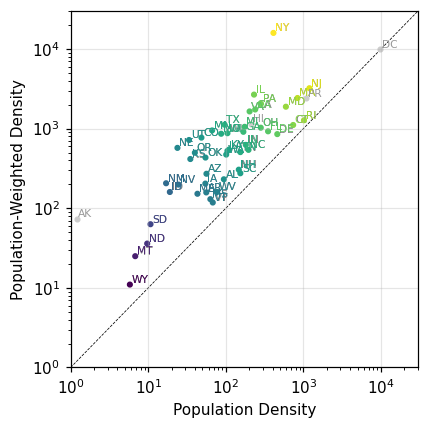

In [167]:
fig, ax = plt.subplots(figsize=(4,4), dpi=110)
d = latest[latest.Deaths > 0]
X = d.population_density
Y = d.population_weighted_density
greys = latest.State.isin('DC PR HI AK'.split())
both = np.log(X * Y)
sc = ax.scatter(X[~greys], Y[~greys], marker='.', c=both[~greys])
ax.scatter(X[greys], Y[greys], marker='.', c='.8')
for (i,(x, y, z, g)) in enumerate(zip(X.values, Y.values, both.values, greys)):
    x, y = 1.05*x, 1.05*y
    c = '.6' if g else sc.to_rgba(z)
    ax.text(x, y, d.State.values[i], color=c, size='x-small')
    offset = 1.005
    if not g:
        ax.text(x*offset, y/offset, d.State.values[i], color='.5', size='x-small', zorder=-20)
ax.loglog()
ax.set_xlabel('Population Density')
ax.set_ylabel('Population-Weighted Density')
lims = 1, 3e4
ax.plot(lims, lims, 'k--', lw=.5, zorder=-10)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
plt.tight_layout()

Maybe it's surprising that population-weighted density is not much better at explaining viral spread than ordinary population density.  But in the end, those two metrics are already strongly correlated.  Also, notice that Alaska and New York are the two most significant population-weightetd density outliers.  Those two states also align better with the bulk trend in terms of deaths vs weighted density, than they do in terms of deaths vs simple density.

## Map Visualizations

It may be instructive to visualize this data as choropleth maps (where color represents some variable).  First we load some geographic data:

In [39]:
us_states = geopandas.read_file('https://github.com/python-visualization/folium/raw/master/tests/us-states.json')
us_states = us_states[~us_states.name.isin(['Alaska', 'Hawaii'])]
us_states.head(3)

id      name                                           geometry
0  AL   Alabama  POLYGON ((-87.35930 35.00118, -85.60667 34.984...
2  AZ   Arizona  POLYGON ((-109.04250 37.00026, -109.04798 31.3...
3  AR  Arkansas  POLYGON ((-94.47384 36.50186, -90.15254 36.496...

In [40]:
states_with_geo = us_states.merge(states2, left_on='id name'.split(), right_on='State name'.split())
states_with_geo['Date'] = states_with_geo.Date.astype(str)

In [41]:
states_with_geo.tail(3)

id     name                                           geometry  \
3520  WY  Wyoming  POLYGON ((-109.08084 45.00207, -105.91517 45.0...   
3521  WY  Wyoming  POLYGON ((-109.08084 45.00207, -105.91517 45.0...   
3522  WY  Wyoming  POLYGON ((-109.08084 45.00207, -105.91517 45.0...   

            Date State  Positive  Negative  Pending  Recovered  Deaths  ...  \
3520  2020-05-14    WY     701.0   14729.0      NaN      480.0     7.0  ...   
3521  2020-05-15    WY     715.0   15307.0      NaN      487.0     7.0  ...   
3522  2020-05-16    WY     716.0   15678.0      NaN      496.0     7.0  ...   

     population  housing_units  land_area  population_density  \
3520     563626         261868   97093.14                 5.8   
3521     563626         261868   97093.14                 5.8   
3522     563626         261868   97093.14                 5.8   

      housing_density  population_weighted_density  housing_weighted_density  \
3520              2.7                           11                         5   
3521              2.7                           11                         5   
3522              2.7                           11                         5   

      Deaths Per Million  Positive Cases Per Million  Recoveries Per Million  
3520           12.419583                 1243.732546              851.628562  
3521           12.419583                 1268.571712              864.048145  
3522           12.419583                 1270.345939              880.016181  

[3 rows x 22 columns]

Then we begin with some static maps.

In [42]:
def make_map(column, title=None):
    # set up figure
    height = 500
    width = height // 2 * 3
    p = bp.figure(title=title or column, tools='', plot_height=height, plot_width=width)
    p.title.text_font_size = '20pt'
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.xgrid.visible = False
    p.ygrid.visible = False
    p.outline_line_color = None
    
    # set up data
    data = states_with_geo[states_with_geo.Date == states_with_geo.Date.max()].copy()
    nanmask = data.Recovered.isna()
    data.loc[nanmask, 'Recovered'] = '(no data)'
    data['population_density'] = data.population_density.astype(int)

    # set palette
    palette = brewer['YlGnBu'][9][::-1]

    # set up color map
    color_mapper = bm.LinearColorMapper(palette=palette, low=0, high=data[column].max())

    # set colorbar ticks
    formatter = bm.formatters.PrintfTickFormatter(format='%.0f')

    # color states by selected column
    geosource = bm.GeoJSONDataSource(geojson=data.to_json())
    state_patches = p.patches(
        'xs', 'ys', source=geosource,
        line_color='gray', 
        line_width=0.25, 
        fill_alpha=.7,
        line_alpha=.3,
        fill_color = {'field': column,
                      'transform' : color_mapper}
    )

    # format tooltips
    p.add_tools(bm.HoverTool(
        renderers=[state_patches],
        tooltips=[
            ('State:', '@name'),
            ('Deaths:', '@Deaths'),
            ('Positive Cases:', '@Positive'),
            ('Recoveries', '@Recovered'),
            ('Population', '@population'),
            ('Population Density', '@population_density'),
            ('Population-Weighted Density', '@population_weighted_density'),
        ]
    ))

    # create color bar
    color_bar = bm.ColorBar(color_mapper = color_mapper, 
                            formatter=formatter,
                            width=int(.5*width), height=15,
                            location=(200,0), 
                            orientation='horizontal',
                         )
    p.add_layout(color_bar, 'above')

    return p

In [43]:
bp.show(make_map('Deaths', 'Deaths to-date'))
bp.show(make_map('Deaths Per Million'))
bp.show(make_map('Positive', 'Positive Cases'))
bp.show(make_map('Positive Cases Per Million'))

All of these maps continue telling the story above: the largest outbreak is in New York, and nearby regions are also affected.

In [44]:
def make_slider_map(column, title=None, fractional=False, weekly=False, log=False):
    # set up figure
    height = 500
    width = height // 2 * 3
    title = title or column
    if weekly:
        title = 'Weekly New ' + title
    if fractional:
        title += f' (percent relative to total)'
    p = bp.figure(title=title, tools='', plot_height=height, plot_width=width)
    p.title.text_font_size = '20pt'
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.xgrid.visible = False
    p.ygrid.visible = False
    p.outline_line_color = None

    # pivot selected column by date for use with slider
    last_day = states.days.max()
    init_day = last_day * 3 // 4 if (fractional and not weekly) else last_day
    days = states_with_geo.pivot(index='State', columns='days', values=column)
    days = orig_days = days.T.fillna(method='bfill').T
    if weekly:
        days = days.T.rolling(7).sum().diff().T
    if fractional:
        for day in states.days.unique():
            days[day] = 100 * days[day] / orig_days[last_day]
    days = days.rename(columns={n: f'day_{n}' for n in states.days.unique()})

    # join pivot table with main data
    data = states_with_geo[states_with_geo.days == last_day].copy()
    data = data.merge(days, on='State')
    nanmask = data.Recovered.isna()
    data.loc[nanmask, 'Recovered'] = '(no data)'
    data['population_density'] = data.population_density.astype(int)

    # set palette
    palette = brewer['Blues' if fractional else 'YlGnBu'][9][::-1]

    # set up color map
    if weekly:
        top = int(np.ceil(np.nanmax(days.values)))
    elif fractional:
        top = 100
    else:
        top = data[column].max()
    if log:
        low = 1
        mapper = bm.LogColorMapper
    else:
        low = 0
        mapper = bm.LinearColorMapper
    color_mapper = mapper(palette=palette, low=low, high=top)

    # set colorbar ticks
    if not log:
        formatter = bm.formatters.PrintfTickFormatter(format='%.0f' + ('%%' if fractional else ''))

    # color states by number of deaths
    geosource = bm.GeoJSONDataSource(geojson=data.to_json())
    state_patches = p.patches(
        'xs', 'ys', source=geosource,
        line_color='gray', 
        line_width=0.25, 
        #fill_alpha=1 if fractional else .7,
        line_alpha=.3,
        fill_color = {'field': f'day_{init_day}',
                      'transform' : color_mapper}
    )

    # format tooltips
    hover =  bm.HoverTool(
        renderers=[state_patches],
        tooltips=[
            ('State:', '@name'),
            ('Deaths:', '@Deaths'),
            ('Positive Cases:', '@Positive'),
            ('Recoveries', '@Recovered'),
            ('Population', '@population'),
            ('Population Density', '@population_density'),
            ('Population-Weighted Density', '@population_weighted_density'),
        ]
    )
    p.add_tools(hover)

    # create color bar
    if log:
        kw = dict(ticker=bm.LogTicker())
    else:
        kw = dict(formatter=formatter)
    color_bar = bm.ColorBar(color_mapper = color_mapper, 
                            width=int(.5*width), height=15,
                            location=(200,0), 
                            orientation='horizontal',
                            **kw )
    p.add_layout(color_bar, 'above')
    
    # add date indicator
    dates = list(map(str,np.sort(states_with_geo.Date.unique())))
    date_label = bm.Label(
        x=70, y=50, x_units='screen', y_units='screen',
        text=dates[init_day],
        text_font_style='bold',
        background_fill_color='white', background_fill_alpha=1.0)
    p.add_layout(date_label)

    # add slider
    slider = bm.Slider(
        start=7 if weekly else 0, end=last_day,
        value=init_day, step=1,
        title='Days since January 22')
    cb_days = bm.CustomJS(
        args=dict(patches=state_patches, hover=hover, source=geosource, label=date_label, dates=dates),
        code=f"""
        // update patches
        var selected_day = cb_obj.value;
        var day = 'day_' + selected_day
        patches.glyph.fill_color.field = day;
        // update date label
        label.text = dates[selected_day];
        // TODO: how to update hover tooltips?
        //hover.tooltips = [("State", "@State"), ("{title}", "@day")]
        source.change.emit(); """)
    slider.js_on_change('value', cb_days)

    layout = bl.gridplot([[p],[slider]])

    return layout

In [45]:
bp.show(make_slider_map('Deaths', 'Deaths to-date', log=True))
bp.show(make_slider_map('Deaths Per Million', log=True))
bp.show(make_slider_map('Positive', 'Positive Cases', log=True))
bp.show(make_slider_map('Positive Cases Per Million', log=True))

In this batch of maps, you can move the slider to change the time slice.

In [46]:
bp.show(make_slider_map('Deaths', 'Deaths to-date', fractional=True))
bp.show(make_slider_map('Positive', 'Positive Cases', fractional=True))

These maps shows the fractional accumulation of values, reaching 100% in every state when the slider is all the way to the right.  States that turn blue later are ones in which the spread is less contained.

In [47]:
! mkdir -p exports

In [48]:
bp.show(make_slider_map('Deaths', weekly=True, log=True))
bp.show(make_slider_map('Positive', 'Positive Cases', weekly=True, log=True))
bp.show(make_slider_map('Deaths', fractional=True, weekly=True))
bp.show(make_slider_map('Positive', 'Positive Cases', fractional=True, weekly=True))

These plots show weekly (rolling sum) new deaths/cases as percent of each state's total.  This is perhaps the clearest picture of how the virus has spread through each state over time.

Next cell exports these plots to standalone HTML.

In [73]:
p = make_slider_map('Deaths', 'Deaths to-date', log=True)
print(bp.save(p, 'exports/map_deaths.html',
              title='Deaths ', resources=CDN))

p = make_slider_map('Positive', 'Positive Cases to-date', log=True)
print(bp.save(p, 'exports/map_positive_cases.html',
              title='Positive Cases', resources=CDN))

p = make_slider_map('Deaths', weekly=True, log=True)
print(bp.save(p, 'exports/map_weekly_deaths.html',
              title='Weekly New Deaths', resources=CDN))

p = make_slider_map('Positive', 'Positive Cases', weekly=True, log=True)
print(bp.save(p, 'exports/map_weekly_positive_cases.html',
              title='Weekly New Positive Cases', resources=CDN))

p = make_slider_map('Deaths', fractional=True, weekly=True)
print(bp.save(p, 'exports/map_weekly_deaths_fractional.html',
              title='Weekly New Deaths', resources=CDN))

p = make_slider_map('Positive', 'Positive Cases', fractional=True, weekly=True)
print(bp.save(p, 'exports/map_weekly_positive_cases_fractional.html',
              title='Weekly New Positive Cases', resources=CDN))

/home/mike/nb/data-science-one-offs/exports/map_deaths.html
/home/mike/nb/data-science-one-offs/exports/map_positive_cases.html
/home/mike/nb/data-science-one-offs/exports/map_weekly_deaths.html
/home/mike/nb/data-science-one-offs/exports/map_weekly_positive_cases.html
/home/mike/nb/data-science-one-offs/exports/map_weekly_deaths_fractional.html
/home/mike/nb/data-science-one-offs/exports/map_weekly_positive_cases_fractional.html


## Conclusions

* We're eff'd.

Stay home if you can, wear a mask when you go out.  Keep your distance from your neighbors like your and their lives depend on it – because they do.

Be safe out there.